# Model SIM 

Model SIM is introduced in chapter 3 of {cite:t}`GodleyLavoie2006MonetaryEconomicsIntegrated` "Monetary Economics: An Integrated Approach to Credit, Money, Income, Production and Wealth" and represents the "simplest model with government money". That is, this is a model with only _outside money_ (from the government).

## Module Contents

As with all `MacroStat` models, SIM is divided into Variables, Parameters (fixed constants), Scenarios, and the Behavior (model initialization and steps). The module-level documentation, such as all variables/parameters/scenarios and their notation or the behavioral equations associated with each function of `BehaviorSIM.py` can be seen in:

```{eval-rst}
.. toctree::
    :maxdepth: 2

    Variables <GL06SIM/variables.rst>
    Parameters <GL06SIM/parameters.rst>
    Equations <GL06SIM/behavior.rst>
    Scenarios <GL06SIM/scenarios.rst>
```

:::{Note}
The remainder of this page gives an introduction to the model, notes on how it is implemented in `MacroStat` and then shows some of the model dynamics by replicating the relevant graphs of Godley and Lavoie (2006).
:::

## Model Overview

### Behavioral Equations

The SIM model is introduced in Chapter 3, and consists of the following 11 equations and 11 unknowns:

1. Consumption good supply equals demand
```{math}
:label: gl06_sim_eq301_consumptionClearing
C_s(t) = C_d(t)
```
2. Governmend good supply equals demand
```{math}
:label: gl06_sim_eq302_governmentClearing
G_s(t) = G_d(t)
```
3. Tax supply equals demand
```{math}
:label: gl06_sim_eq303_taxClearing
T_s(t) = T_d(t)
```
4. Labour supply equals demand
```{math}
:label: gl06_sim_eq304_labourClearing
N_s(t) = N_d(t)
```
5. Disposable income is wage income minus taxes
```{math}
:label: gl06_sim_eq305_disposableIncome
YD(t) = W(t)\cdot N_s(t) - T_s(t)
```
6. Tax demand is a fixed proportion of wage income
```{math}
:label: gl06_sim_eq306_taxDemand
T_d(t) = \theta\cdot W(t)\cdot N_s(t)
```
7. Consumption demand is a share of disposable income and deposits
```{math}
:label: gl06_sim_eq307_consumptionDemand
C_d(t) = \alpha_1\cdot YD(t) + \alpha_2\cdot H_h(t-1)
```
8. The change in government stock of money is demand minus tax
```{math}
:label: gl06_sim_eq308_governmentDeposits
\Delta H_s(t) = H_s(t) - H_s(t-1) = G_d(t) - T_d(t)
```
9. The change in household deposits is disposable income minus expenditure
```{math}
:label: gl06_sim_eq309_householdDeposits
\Delta H_h(t) = H_h(t) - H_h(t-1) = YD(t) - C_d(t)
```
8. Total national income is consumption of households and government
```{math}
:label: gl06_sim_eq310_nationalIncome
Y(t) = C_s(t) + G_s(t)
```
8. Labour Demand is national income over wages
```{math}
:label: gl06_sim_eq311_labourDemand
N_d(t) = \frac{Y(t)}{W(t)}
```

With the redundant equation being
```{math}
:label: gl06_sim_eq312_redundant
\Delta H_s(t) = \Delta H_h(t)
```


### Transaction Flow Matrix

The accounting of transactions for model SIM is as follows:

```{csv-table} Accounting Transaction Matrix for Model SIM
:file: GL06SIM/transaction_matrix.csv
:header-rows: 2
:stub-columns: 1
```

### Balance Sheet Matrix

```{csv-table} Balance Sheet for Model SIM
:file: GL06SIM/balance_sheet.csv
:header-rows: 2
:stub-columns: 1
```

## Implementation in MacroStat

Transposing these eleven equations to the `MacroStat` framework, we consider that there are:

1. Three parameters (fixed constants): $\alpha_1$, $\alpha_2$, and $\theta$ (see [Parameters](GL06SIM/parameters.rst))
2. Two scenario variables : $G_d(t)$ and $W(t)$ (see [Scenarios](GL06SIM/scenarios.rst))
3. The remaining 14 tracked series are variables (see [Variables](GL06SIM/variables.rst))

### Behavioral Modeling

For the implementation of the behavioral equations (see [Behavior](GL06SIM/behavior.rst)), most prior implementations have made use of some form of linear solver or iteration until the system is solved. To simplify the implementation in Macrostat, we can note that the system can be solved analytically for a given timestep as follows:

Substitute into Eq. {eq}`gl06_sim_eq311_labourDemand` to obtain
```{math}
N_d(t) =\frac{1}{W(t)}(C_d(t) + G_d(t))
```
where we can already note that $W(t)$ and $G_d(t)$ are exogenously given (they are scenario variables). This leaves us to solve for $C_d(t)$, where we can use Eq. {eq}`gl06_sim_eq307_consumptionDemand` and Eq. {eq}`gl06_sim_eq305_disposableIncome` to obtain
```{math}
N_d(t) =\frac{1}{W(t)}(\alpha_1(1-\theta)W(t)N_s(t) + \alpha_2 H_h(t-1) + G_d)
```
now noting from Eq. {eq}`gl06_sim_eq304_labourClearing` that supply=demand, we can rewrite the above as
```{math}
:label: gl06_sim_eq13_solutionLabourDemand
N_d(t) =\frac{\alpha_2 H_h(t-1) + G_d}{W(t)(1-\alpha_1(1-\theta))}
```

Therefore, for a given period $t$ we can solve the system by solving, in order:
1. Eq. {eq}`gl06_sim_eq302_governmentClearing` given the scenario variable
2. Eq. {eq}`gl06_sim_eq13_solutionLabourDemand` for labour demand based on prior information $H_h(t)$ and scenario variables $W(t)$ and $G_d(t)$ (this replaces the need to run Eq. {eq}`gl06_sim_eq311_labourDemand`)
3. Eq. {eq}`gl06_sim_eq304_labourClearing`
4. Tax demand, given labour, Eq. {eq}`gl06_sim_eq306_taxDemand`
5. Tax supply, given demand, Eq. {eq}`gl06_sim_eq303_taxClearing`
6. Disposable income, given labour supply and tax demand, Eq. {eq}`gl06_sim_eq305_disposableIncome`
7. Consumption demand, given disposable income, Eq. {eq}`gl06_sim_eq307_consumptionDemand`
8. Consumption supply, given demand, Eq. {eq}`gl06_sim_eq301_consumptionClearing`
9. Government stock of money, Eq. {eq}`gl06_sim_eq308_governmentDeposits`
10. Household stock of deposits, Eq. {eq}`gl06_sim_eq309_householdDeposits`
11. National income, Eq. {eq}`gl06_sim_eq310_nationalIncome`

This is implemented as such in the [Behavior](GL06SIM/behavior.rst) class. 

## Model Dynamics

### Preparatory Steps

In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
from macrostat.models import get_model

plt.style.use("../../macrostat.mplstyle")

### Convergence to the Steady State

In {cite:t}`GodleyLavoie2006MonetaryEconomicsIntegrated` models are initialized with almost all of the variables set to zero. For model SIM the only non-zero item is that in period 0 the government demand is 20, i.e. the government creates 20 monetary units of demand. Thereafter the system converges to a steady state. We can see this by simulating the default parameters and checking that total national income is 100. 

In [2]:
GLO6SIM = get_model("GL06SIM")
model = GLO6SIM()
model.simulate()
output = model.variables.to_pandas()

#### National Income

In [3]:
steady_state_income = model.scenarios[(0,"GovernmentDemand")][0] / model.parameters["TaxRate"]

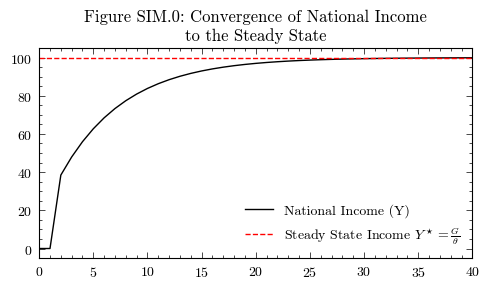

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(5, 3))
axs.plot(output.index, output['NationalIncome'], color='k', label='National Income (Y)')
axs.axhline(y=steady_state_income, color='r', linestyle='--', label=r'Steady State Income $Y^\star=\frac{G}{\theta}$')
axs.legend(loc='lower right', frameon=False)
axs.set_xlim(0,40)
axs.set_title('Figure SIM.0: Convergence of National Income\nto the Steady State')
plt.tight_layout()
plt.show()


#### Disposable Income and Consumption

Corresponding to Figure 3.2 "Disposable income and consumption starting from scratch"

In [5]:
steady_state_consumption= (model.scenarios[(0,"GovernmentDemand")][0] * (1-model.parameters["TaxRate"])) / model.parameters["TaxRate"]

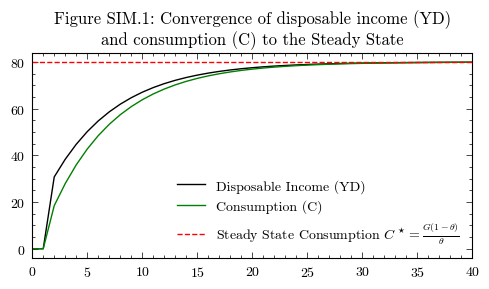

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(5, 3))
axs.plot(output.index, output['DisposableIncome'], color='k', label='Disposable Income (YD)')
axs.plot(output.index, output['ConsumptionDemand'], color='g', label='Consumption (C)')
axs.axhline(y=steady_state_consumption, color='r', linestyle='--', label=r'Steady State Consumption $C^\star=\frac{G(1-\theta)}{\theta}$')
axs.legend(loc='lower right', frameon=False)
axs.set_xlim(0,40)
axs.set_title('Figure SIM.1: Convergence of disposable income (YD)\nand consumption (C) to the Steady State')
plt.tight_layout()
plt.show()


#### Wealth and Savings

Corresponding to Figure 3.3 "Wealth change and wealth level, starting from scratch (Table 3.4)"

In [7]:
alpha3 = (1-model.parameters["PropensityToConsumeSavings"]) / model.parameters["PropensityToConsumeIncome"]
steady_state_wealth = alpha3 * (model.scenarios[(0,"GovernmentDemand")][0] * (1-model.parameters["TaxRate"])) / model.parameters["TaxRate"]

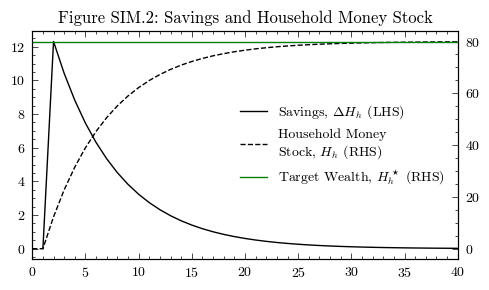

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(5, 3))
line1 = axs.plot(output.index, output['HouseholdMoneyStock'].diff(), color='k', label='Savings, $\Delta H_h$ (LHS)')
ax2 = axs.twinx()
line2 = ax2.plot(output.index, output['HouseholdMoneyStock'], color='k', linestyle='--', label='Household Money\nStock, $H_h$ (RHS)')
line3 = ax2.axhline(y=steady_state_wealth, color='g', label='Target Wealth, $H_h^\star$ (RHS)')
lines = line1 + line2 + [line3]
labels = [l.get_label() for l in lines]
axs.legend(lines, labels, loc='center right', frameon=False)
axs.set_xlim(0,40)
axs.set_title('Figure SIM.2: Savings and Household Money Stock')
plt.tight_layout()
plt.show()


### Perturbations in the Steady State

Following the convergence to the steady state, we can introduce a shock in government spending, increasing it by 5 units. Accordingly, the steady state given by $Y^\star=\frac{G}{\theta}$ would shift to $Y^\star=125$

This kind of scenario can easily be implemented in the `MacroStat` version by adding a scenario:
1. Noting that we have convergence to the steady state at period 40, let us set this as the scenario trigger
2. We then need a new timeseries for the scenario, where $G=25$ from the trigger period onwards

In [9]:
model.parameters["scenario_trigger"] = 40
model.scenarios.add_scenario(
    name="GovernmentDemandIncrease",
    timeseries={"GovernmentDemand":25}
)
model.simulate(scenario="GovernmentDemandIncrease")
output_government_demand_increase = model.variables.to_pandas()

#### National Income

In [10]:
steady_state_income_new = model.scenarios[("GovernmentDemandIncrease","GovernmentDemand")][-1] / model.parameters["TaxRate"]

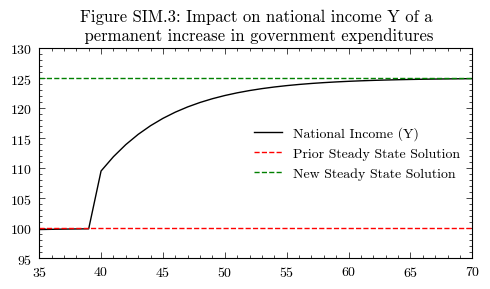

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(5, 3))
axs.plot(output_government_demand_increase['NationalIncome'], color='k', label='National Income (Y)')
axs.axhline(y=steady_state_income, color='r', linestyle='--', label='Prior Steady State Solution')
axs.axhline(y=steady_state_income_new, color='g', linestyle='--', label='New Steady State Solution')
axs.legend(loc='center right', frameon=False)
axs.set_xlim(35,70)
axs.set_ylim(95,130)
axs.set_title('Figure SIM.3: Impact on national income Y of a\n permanent increase in government expenditures')
plt.tight_layout()
plt.show()


#### Consumption and Wealth

In [12]:
steady_state_wealth_new = alpha3 * (model.scenarios[("GovernmentDemandIncrease","GovernmentDemand")][-1] * (1-model.parameters["TaxRate"])) / model.parameters["TaxRate"]

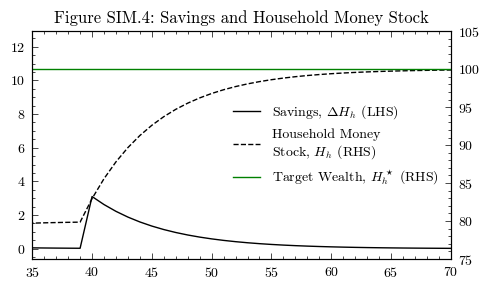

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(5, 3))
line1 = axs.plot(output_government_demand_increase['HouseholdMoneyStock'].diff(), color='k', label='Savings, $\Delta H_h$ (LHS)')
ax2 = axs.twinx()
line2 = ax2.plot(output_government_demand_increase['HouseholdMoneyStock'], color='k', linestyle='--', label='Household Money\nStock, $H_h$ (RHS)')
line3 = ax2.axhline(y=steady_state_wealth_new, color='g', label='Target Wealth, $H_h^\star$ (RHS)')
lines = line1 + line2 + [line3]
labels = [l.get_label() for l in lines]
axs.legend(lines, labels, loc='center right', frameon=False)
axs.set_xlim(35,70)
ax2.set_ylim(75,105)
axs.set_title('Figure SIM.4: Savings and Household Money Stock')
plt.tight_layout()
plt.show()
